# DDP does not work in jupyter notebook enironment

In [17]:
!pip install pynvml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 1.1 MB/s eta 0:00:001.9 MB/s eta 0:00:01


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import torch.multiprocessing as mp
from torch.utils.data.distributed import DistributedSampler
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed import init_process_group, destroy_process_group

import os
from time import time
from matplotlib import pyplot as plt

In [2]:
# environment
device = "cpu"
world_size = 1
if torch.cuda.is_available():
    device = "cuda"
    world_size = torch.cuda.device_count()
print(f"device: {device}")
print(f"world size (devices available): {world_size}")
for i in range(world_size):
    dev = device+":"+str(i)
    print(f"Device {dev} {torch.cuda.get_device_properties(i)}")
    print(f"Cuda capability {dev} {torch.cuda.get_device_capability(i)}")

device: cuda
world size (devices available): 2
Device cuda:0 _CudaDeviceProperties(name='NVIDIA GeForce RTX 2080 Ti', major=7, minor=5, total_memory=11011MB, multi_processor_count=68)
Cuda capability cuda:0 (7, 5)
Device cuda:1 _CudaDeviceProperties(name='NVIDIA GeForce RTX 2080 Ti', major=7, minor=5, total_memory=11008MB, multi_processor_count=68)
Cuda capability cuda:1 (7, 5)


In [3]:
# x = torch.rand(1024, 1024, device='cuda:0')
# y = torch.rand(1024, 1024, device='cuda:1')
# torch.cuda.nccl.is_available([x, y])
# https://pytorch.org/docs/stable/distributed.html
print(f"nccl {torch.distributed.is_nccl_available()}")
print(f"gloo {torch.distributed.is_gloo_available()}")
print(f"mpi {torch.distributed.is_mpi_available()}")

nccl True
gloo True
mpi False


In [4]:
# data
def get_data_loader(isTrain: bool, batch_size: int):
    # data_set = datasets.EMNIST(root="datasets/", train=isTrain, transform=transforms.ToTensor(), download=True,
    #                            split="digits")
    data_set = datasets.MNIST(root="datasets/", train=isTrain, transform=transforms.ToTensor(), download=True)
    return DataLoader(
        data_set,
        batch_size=batch_size * torch.cuda.device_count(),
        pin_memory=True,
        shuffle=True,
        num_workers=4
    )

In [5]:
data_set = datasets.EMNIST(root="datasets/", train=True, transform=transforms.ToTensor(), download=True, split="digits")
print(data_set.targets.shape)
print(data_set.data.shape[1])
print(data_set.targets.unique(return_counts=True))
print(data_set.targets.unique().shape[:1][0])

torch.Size([240000])
28
(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), tensor([24000, 24000, 24000, 24000, 24000, 24000, 24000, 24000, 24000, 24000]))
10


In [6]:
# hyper parameters
input_size = data_set.data.shape[1] * data_set.data.shape[2]
num_classes = data_set.targets.unique().shape[:1][0]


In [7]:
# model
class net(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 50)
        self.fc2 = nn.Linear(50, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [8]:
from torchsummary import summary
m = net(input_size, num_classes)
m.to("cuda")
summary(m,(1,input_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 50]          39,250
            Linear-2                [-1, 1, 10]             510
Total params: 39,760
Trainable params: 39,760
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.15
Estimated Total Size (MB): 0.16
----------------------------------------------------------------


In [9]:
def accuracy(model, loader, device):
    num_correct = 0
    num_samples = 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            x = x.reshape(x.shape[0], -1)
            y = y.to(device)
            scores = model(x)
            _, pred = scores.max(1)
            num_correct += (pred == y).sum()
            num_samples += pred.size(0)
    model.train()
    acc = float(num_correct)/float(num_samples) * 100
    # print(f"Accuracy: {acc}")
    return acc

In [10]:
def train(model, device, data_loader, epochs, optimizer, criterion):
    model = model.to(device)
    model = torch.nn.DataParallel(model)
    
    accuracy_per_epoch = []
    accuracy_per_batch = []
    for epoch in range(epochs):
        print(f"Training on Device {device} run epoch {epoch}, batch size: {data_loader.batch_size / torch.cuda.device_count()}")
        # run a batch:
        i = 0
        for x, y in data_loader:
            x = x.to(device)
            x = x.reshape(x.shape[0], -1)
            y = y.to(device)
            score = model(x)
            loss = criterion(score, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # acc = accuracy(model, data_loader, device)
            # print(f"Training on Device {device} run epoch {epoch} step {i} accuracy {acc}")
            # accuracy_per_batch.append(acc)
            i += 1
        acc = accuracy(model, data_loader, device)
        accuracy_per_epoch.append(acc)
    return accuracy_per_epoch
        

In [11]:

def main(device, epochs, batch_size, input_size, num_classes):
    data_loader = get_data_loader(isTrain=True, batch_size=batch_size)
    model = net(input_size=input_size, num_classes=num_classes)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()
    convergence = train(model=model, device=device, data_loader=data_loader, epochs=epochs, optimizer=optimizer, criterion=criterion)
    return convergence
    

In [20]:
def print_convergence(conv_arr, batch_size):
    x = range(len(conv_arr))
    plt.title("Accuracy convergence MNIST batch size " + str(batch_size) + "max acc:" + str(conv_arr[-1]))
    plt.plot(x, conv_arr, color="red")
    plt.show()

In [21]:

epochs = 20
batch_size = [2,4,8,16,32,64,128,256]
input_size = 28 * 28
num_classes = 10
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"


Training on Device cuda run epoch 0, batch size: 2.0
Training on Device cuda run epoch 1, batch size: 2.0
Training on Device cuda run epoch 2, batch size: 2.0
Training on Device cuda run epoch 3, batch size: 2.0
Training on Device cuda run epoch 4, batch size: 2.0
Training on Device cuda run epoch 5, batch size: 2.0
Training on Device cuda run epoch 6, batch size: 2.0
Training on Device cuda run epoch 7, batch size: 2.0
Training on Device cuda run epoch 8, batch size: 2.0
Training on Device cuda run epoch 9, batch size: 2.0
Training on Device cuda run epoch 10, batch size: 2.0
Training on Device cuda run epoch 11, batch size: 2.0
Training on Device cuda run epoch 12, batch size: 2.0
Training on Device cuda run epoch 13, batch size: 2.0
Training on Device cuda run epoch 14, batch size: 2.0
Training on Device cuda run epoch 15, batch size: 2.0
Training on Device cuda run epoch 16, batch size: 2.0
Training on Device cuda run epoch 17, batch size: 2.0
Training on Device cuda run epoch 18, 

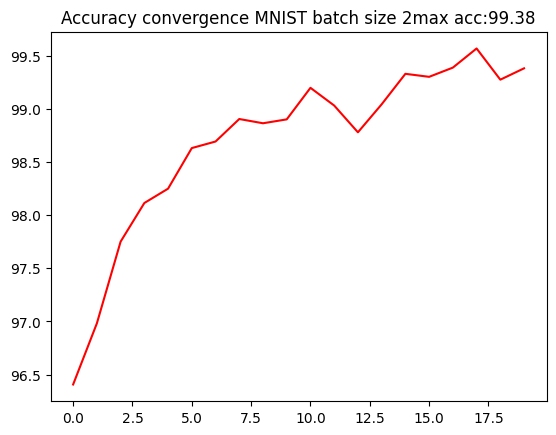

Training on Device cuda run epoch 0, batch size: 4.0
Training on Device cuda run epoch 1, batch size: 4.0
Training on Device cuda run epoch 2, batch size: 4.0
Training on Device cuda run epoch 3, batch size: 4.0
Training on Device cuda run epoch 4, batch size: 4.0
Training on Device cuda run epoch 5, batch size: 4.0
Training on Device cuda run epoch 6, batch size: 4.0
Training on Device cuda run epoch 7, batch size: 4.0
Training on Device cuda run epoch 8, batch size: 4.0
Training on Device cuda run epoch 9, batch size: 4.0
Training on Device cuda run epoch 10, batch size: 4.0
Training on Device cuda run epoch 11, batch size: 4.0
Training on Device cuda run epoch 12, batch size: 4.0
Training on Device cuda run epoch 13, batch size: 4.0
Training on Device cuda run epoch 14, batch size: 4.0
Training on Device cuda run epoch 15, batch size: 4.0
Training on Device cuda run epoch 16, batch size: 4.0
Training on Device cuda run epoch 17, batch size: 4.0
Training on Device cuda run epoch 18, 

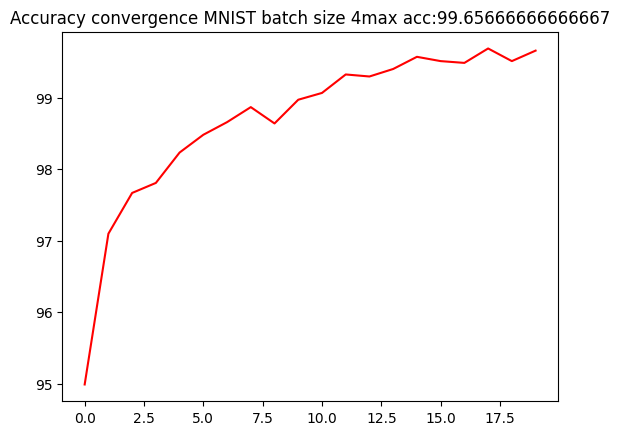

Training on Device cuda run epoch 0, batch size: 8.0
Training on Device cuda run epoch 1, batch size: 8.0
Training on Device cuda run epoch 2, batch size: 8.0
Training on Device cuda run epoch 3, batch size: 8.0
Training on Device cuda run epoch 4, batch size: 8.0
Training on Device cuda run epoch 5, batch size: 8.0
Training on Device cuda run epoch 6, batch size: 8.0
Training on Device cuda run epoch 7, batch size: 8.0
Training on Device cuda run epoch 8, batch size: 8.0
Training on Device cuda run epoch 9, batch size: 8.0
Training on Device cuda run epoch 10, batch size: 8.0
Training on Device cuda run epoch 11, batch size: 8.0
Training on Device cuda run epoch 12, batch size: 8.0
Training on Device cuda run epoch 13, batch size: 8.0
Training on Device cuda run epoch 14, batch size: 8.0
Training on Device cuda run epoch 15, batch size: 8.0
Training on Device cuda run epoch 16, batch size: 8.0
Training on Device cuda run epoch 17, batch size: 8.0
Training on Device cuda run epoch 18, 

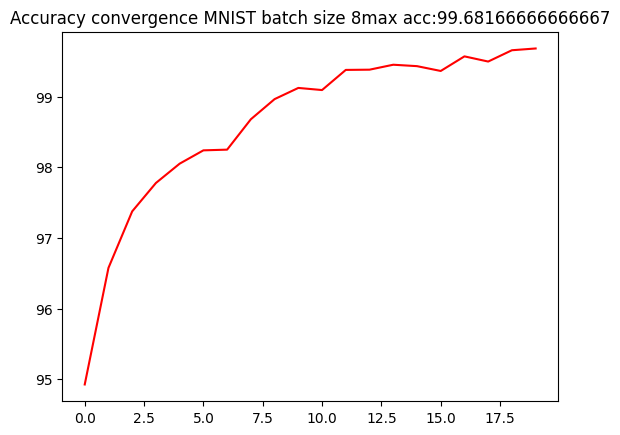

Training on Device cuda run epoch 0, batch size: 16.0
Training on Device cuda run epoch 1, batch size: 16.0
Training on Device cuda run epoch 2, batch size: 16.0
Training on Device cuda run epoch 3, batch size: 16.0
Training on Device cuda run epoch 4, batch size: 16.0
Training on Device cuda run epoch 5, batch size: 16.0
Training on Device cuda run epoch 6, batch size: 16.0
Training on Device cuda run epoch 7, batch size: 16.0
Training on Device cuda run epoch 8, batch size: 16.0
Training on Device cuda run epoch 9, batch size: 16.0
Training on Device cuda run epoch 10, batch size: 16.0
Training on Device cuda run epoch 11, batch size: 16.0
Training on Device cuda run epoch 12, batch size: 16.0
Training on Device cuda run epoch 13, batch size: 16.0
Training on Device cuda run epoch 14, batch size: 16.0
Training on Device cuda run epoch 15, batch size: 16.0
Training on Device cuda run epoch 16, batch size: 16.0
Training on Device cuda run epoch 17, batch size: 16.0
Training on Device c

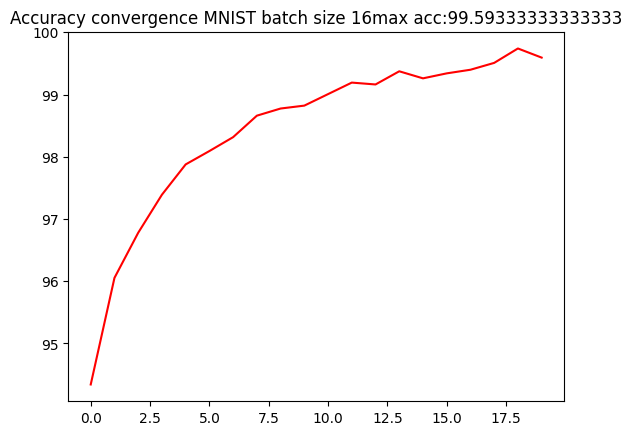

Training on Device cuda run epoch 0, batch size: 32.0
Training on Device cuda run epoch 1, batch size: 32.0
Training on Device cuda run epoch 2, batch size: 32.0
Training on Device cuda run epoch 3, batch size: 32.0
Training on Device cuda run epoch 4, batch size: 32.0
Training on Device cuda run epoch 5, batch size: 32.0
Training on Device cuda run epoch 6, batch size: 32.0
Training on Device cuda run epoch 7, batch size: 32.0
Training on Device cuda run epoch 8, batch size: 32.0
Training on Device cuda run epoch 9, batch size: 32.0
Training on Device cuda run epoch 10, batch size: 32.0
Training on Device cuda run epoch 11, batch size: 32.0
Training on Device cuda run epoch 12, batch size: 32.0
Training on Device cuda run epoch 13, batch size: 32.0
Training on Device cuda run epoch 14, batch size: 32.0
Training on Device cuda run epoch 15, batch size: 32.0
Training on Device cuda run epoch 16, batch size: 32.0
Training on Device cuda run epoch 17, batch size: 32.0
Training on Device c

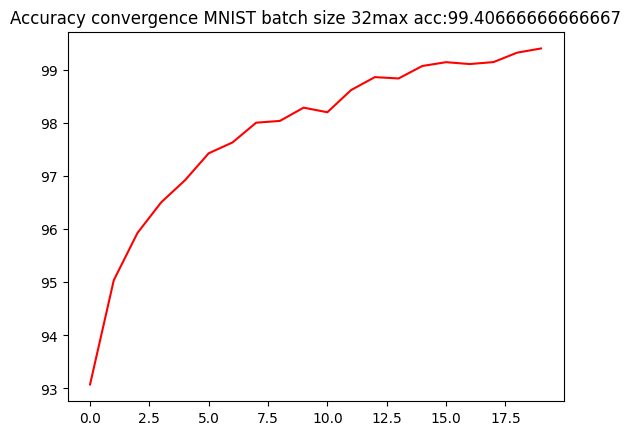

Training on Device cuda run epoch 0, batch size: 64.0
Training on Device cuda run epoch 1, batch size: 64.0
Training on Device cuda run epoch 2, batch size: 64.0
Training on Device cuda run epoch 3, batch size: 64.0
Training on Device cuda run epoch 4, batch size: 64.0
Training on Device cuda run epoch 5, batch size: 64.0
Training on Device cuda run epoch 6, batch size: 64.0
Training on Device cuda run epoch 7, batch size: 64.0
Training on Device cuda run epoch 8, batch size: 64.0
Training on Device cuda run epoch 9, batch size: 64.0
Training on Device cuda run epoch 10, batch size: 64.0
Training on Device cuda run epoch 11, batch size: 64.0
Training on Device cuda run epoch 12, batch size: 64.0
Training on Device cuda run epoch 13, batch size: 64.0
Training on Device cuda run epoch 14, batch size: 64.0
Training on Device cuda run epoch 15, batch size: 64.0
Training on Device cuda run epoch 16, batch size: 64.0
Training on Device cuda run epoch 17, batch size: 64.0
Training on Device c

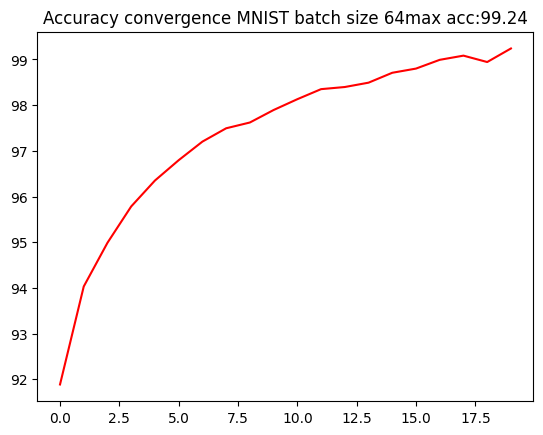

Training on Device cuda run epoch 0, batch size: 128.0
Training on Device cuda run epoch 1, batch size: 128.0
Training on Device cuda run epoch 2, batch size: 128.0
Training on Device cuda run epoch 3, batch size: 128.0
Training on Device cuda run epoch 4, batch size: 128.0
Training on Device cuda run epoch 5, batch size: 128.0
Training on Device cuda run epoch 6, batch size: 128.0
Training on Device cuda run epoch 7, batch size: 128.0
Training on Device cuda run epoch 8, batch size: 128.0
Training on Device cuda run epoch 9, batch size: 128.0
Training on Device cuda run epoch 10, batch size: 128.0
Training on Device cuda run epoch 11, batch size: 128.0
Training on Device cuda run epoch 12, batch size: 128.0
Training on Device cuda run epoch 13, batch size: 128.0
Training on Device cuda run epoch 14, batch size: 128.0
Training on Device cuda run epoch 15, batch size: 128.0
Training on Device cuda run epoch 16, batch size: 128.0
Training on Device cuda run epoch 17, batch size: 128.0
Tr

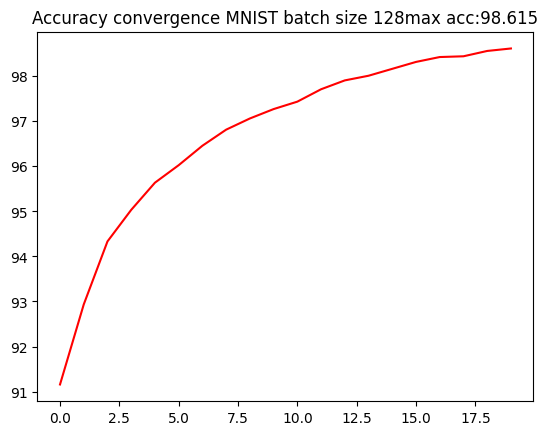

Training on Device cuda run epoch 0, batch size: 256.0
Training on Device cuda run epoch 1, batch size: 256.0
Training on Device cuda run epoch 2, batch size: 256.0
Training on Device cuda run epoch 3, batch size: 256.0
Training on Device cuda run epoch 4, batch size: 256.0
Training on Device cuda run epoch 5, batch size: 256.0
Training on Device cuda run epoch 6, batch size: 256.0
Training on Device cuda run epoch 7, batch size: 256.0
Training on Device cuda run epoch 8, batch size: 256.0
Training on Device cuda run epoch 9, batch size: 256.0
Training on Device cuda run epoch 10, batch size: 256.0
Training on Device cuda run epoch 11, batch size: 256.0
Training on Device cuda run epoch 12, batch size: 256.0
Training on Device cuda run epoch 13, batch size: 256.0
Training on Device cuda run epoch 14, batch size: 256.0
Training on Device cuda run epoch 15, batch size: 256.0
Training on Device cuda run epoch 16, batch size: 256.0
Training on Device cuda run epoch 17, batch size: 256.0
Tr

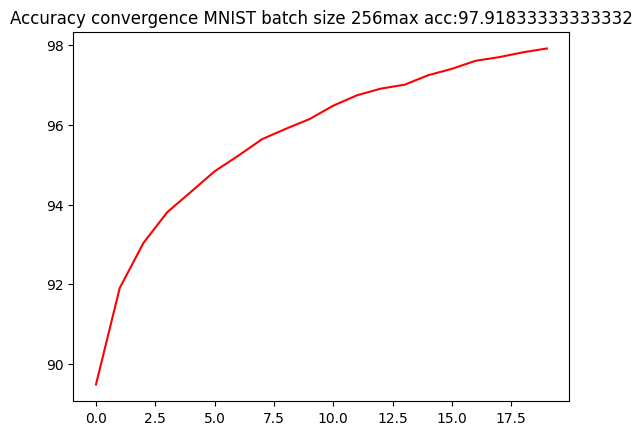

In [22]:
for bs in batch_size:
    #print(bs)
    conv_arr = main(device, epochs, bs, input_size, num_classes)
    print_convergence(conv_arr, bs)

In [19]:
torch.cuda.utilization("cuda:1")

9